In [19]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from glob import glob
import os
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsymmetricPercentileInterval
import h5py 
from astropy.nddata import CCDData
from PIL import Image
from datetime import datetime, timedelta
from ccdproc import ImageFileCollection
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter
from matplotlib import patches
from matplotlib.markers import MarkerStyle
import cmcrameri.cm as cmcm
import cmasher as cmr
from scipy import ndimage
import copy
from juanfit import SpectrumFitSingle, SpectrumFitRow

In [125]:
green_path = "../../src/EclipseSpectra2017/MikesData_l1/Green/"
red_path = "../../src/EclipseSpectra2017/MikesData_l1/Red/"

totality_green_im_collection = ImageFileCollection(green_path,
                        glob_include="TotalitySequence*.fit")
totality_green_df = totality_green_im_collection.summary.to_pandas()
totality_green_df["date-obs"] = pd.to_datetime(totality_green_df["date-obs"])

totality_green_df_cut = totality_green_df.loc[(totality_green_df['date-obs'] >= datetime(2017,8,21,17,46,38)) & 
                                        (totality_green_df['date-obs'] < datetime(2017,8,21,17,47,0))]
totality_green_df_cut = totality_green_df_cut.reset_index(drop=True)

totality_red_im_collection = ImageFileCollection(red_path,
                        glob_include="TotalitySequence*.fit")
totality_red_df = totality_red_im_collection.summary.to_pandas()
totality_red_df["date-obs"] = pd.to_datetime(totality_red_df["date-obs"])

totality_red_df_cut = totality_red_df.loc[(totality_red_df['date-obs'] >= datetime(2017,8,21,17,46,40)) & 
                                        (totality_red_df['date-obs'] < datetime(2017,8,21,17,47,0))]
totality_red_df_cut = totality_red_df_cut.reset_index(drop=True)

In [168]:
FeXI_line_cont_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXILine_ContRatio.fits",unit="adu")
FeXI_line_cont_image = FeXI_line_cont_frame.data
sun_center_FeXI = (np.float64(FeXI_line_cont_frame.header["SUNX"]),np.float64(FeXI_line_cont_frame.header["SUNY"]))
FeXI_line_cont_xslice = slice(372-300,372+301)
FeXI_line_cont_yslice = slice(383-220,383+221)
FeXI_line_cont_cutout = FeXI_line_cont_image[FeXI_line_cont_yslice, FeXI_line_cont_xslice]
FeXI_rotate_center = (sun_center_FeXI[0] - FeXI_line_cont_xslice.start, sun_center_FeXI[1] - FeXI_line_cont_yslice.start)
FeXI_line_cont_image_rot_scipy = ndimage.rotate(FeXI_line_cont_cutout, angle=360 - np.float64(FeXI_line_cont_frame.header["SUNROT"]),reshape=False,order=1)


FeXIV_line_cont_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXIVLine_ContRatio.fits",unit="adu")
FeXIV_line_cont_image = FeXIV_line_cont_frame.data
sun_center_FeXIV = (np.float64(FeXIV_line_cont_frame.header["SUNX"]),np.float64(FeXIV_line_cont_frame.header["SUNY"]))
FeXIV_line_cont_xslice = slice(372-300,372+301)
FeXIV_line_cont_yslice = slice(383-220,383+221)
FeXIV_line_cont_cutout = FeXIV_line_cont_image[FeXIV_line_cont_yslice, FeXIV_line_cont_xslice]
FeXIV_rotate_center = (sun_center_FeXIV[0] - FeXIV_line_cont_xslice.start, sun_center_FeXIV[1] - FeXIV_line_cont_yslice.start)
FeXIV_line_cont_image_rot_scipy = ndimage.rotate(FeXIV_line_cont_cutout, angle=360 - np.float64(FeXIV_line_cont_frame.header["SUNROT"]),reshape=False,order=1)

In [169]:
with h5py.File("../../sav/Eclipse/LimbTrack/sun_pos_linear_fit.h5", 'r') as hf:
    sun_x_fitparam = hf['sun_x_fitparam'][:]
    sun_y_fitparam = hf['sun_y_fitparam'][:]

sun_x_fitpoly = np.poly1d(sun_x_fitparam)
sun_y_fitpoly = np.poly1d(sun_y_fitparam)

In [218]:
slit_pos = 209.4
rsun_arcsec = 950.0
rsun_context_pixel = 71.4
pixel_ratio = rsun_context_pixel/np.float64(FeXI_line_cont_frame.header["MOONR"])
img_pixel_to_arcsec = np.float64(FeXI_line_cont_frame.header["SUNR"])/rsun_arcsec
pixel_ratio_to_arcsec = rsun_context_pixel/np.float64(FeXI_line_cont_frame.header["MOONR"])*img_pixel_to_arcsec
rotate_angle_context = -30

In [10]:
totality_green_df_cut[["date-obs","exptime"]]

,date-obs,exptime
0,2017-08-21 17:46:38,1.0
1,2017-08-21 17:46:40,3.0
2,2017-08-21 17:46:45,1.0
3,2017-08-21 17:46:46,3.0
4,2017-08-21 17:46:44,0.5
5,2017-08-21 17:46:51,1.0
6,2017-08-21 17:46:53,3.0
7,2017-08-21 17:46:50,0.5
8,2017-08-21 17:46:58,1.0
9,2017-08-21 17:46:57,0.5


In [117]:
with h5py.File("../../sav/Eclipse/FlatField/skyflat_green_1d_FeXIV_62nd.h5", 'r') as hf:
    flatfield_1d_FeXIV_62nd = hf['flatfield_1d'][:]

with h5py.File("../../sav/Eclipse/FlatField/skyflat_red_1d_FeX_52nd.h5", 'r') as hf:
    flatfield_1d_FeX_52nd = hf['flatfield_1d'][:]

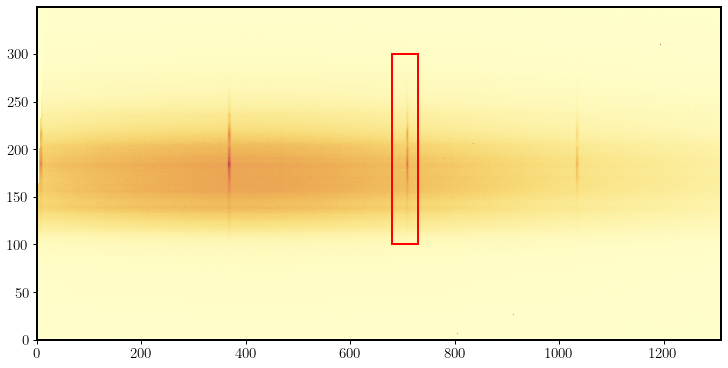

In [22]:
fig, ax = plt.subplots(figsize=(10,5),constrained_layout=True)
green_frame_example = CCDData.read(os.path.join(green_path,totality_green_df_cut.iloc[0]["file"]),hdu=0,unit="adu")
green_frame_wavelength = CCDData.read(os.path.join(green_path,totality_green_df_cut.iloc[0]["file"]),hdu=1,unit="adu").data
ax.pcolormesh(np.arange(green_frame_example.header["NAXIS1"]),
                np.arange(green_frame_example.header["NAXIS2"]),
                green_frame_example.data,cmap=cmcm.lajolla,rasterized=True)

FeXIV_62nd_xslice = slice(680,730)
FeXIV_62nd_yslice = slice(100,300)
cutout_rectangle_62nd = patches.Rectangle((FeXIV_62nd_xslice.start, FeXIV_62nd_yslice.start), 
                    FeXIV_62nd_xslice.stop - FeXIV_62nd_xslice.start,
                    FeXIV_62nd_yslice.stop - FeXIV_62nd_yslice.start,
                    edgecolor="red",facecolor='none',lw=2)
ax.add_patch(cutout_rectangle_62nd)
ax.tick_params(labelsize=15)

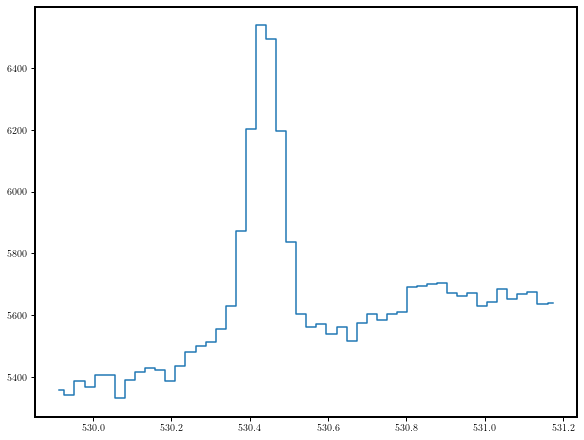

In [74]:
fig, ax = plt.subplots(figsize=(8,6),constrained_layout=True)
ax.step(green_frame_wavelength[FeXIV_62nd_xslice]/62./10., np.average(green_frame_example.data[150:160,FeXIV_62nd_xslice],axis=0),where="mid")

# ax.scatter(green_frame_wavelength[FeXIV_62nd_xslice][np.r_[0:20,40:50]]/62./10.,
#             np.average(green_frame_example.data[150:160,FeXIV_62nd_xslice],axis=0)[np.r_[0:20,40:50]])
# int_sum, cont_fit = calculate_intensity_single(green_frame_wavelength[FeXIV_62nd_xslice][np.r_[0:20,40:50]]/62./10.,
#                 np.average(green_frame_example.data[150:160,FeXIV_62nd_xslice],axis=0)[np.r_[0:20,40:50]],
#     green_frame_wavelength[FeXIV_62nd_xslice]/62./10.,np.average(green_frame_example.data[150:160,FeXIV_62nd_xslice],axis=0))

# ax.plot(green_frame_wavelength[FeXIV_62nd_xslice]/62./10., cont_fit)

In [103]:
def calculate_intensity(image, wvl, wavelength_slice, ypix_slice, cont_slice_1, cont_slice_2):
    image_sliced = image[ypix_slice, wavelength_slice]
    wvl_sliced = wvl[wavelength_slice]
    intensity_sliced = np.zeros(ypix_slice.stop - ypix_slice.start)
    for ii in range(ypix_slice.stop - ypix_slice.start):
        intensity_sliced[ii] = calculate_intensity_single(wvl_sliced[np.r_[cont_slice_1, cont_slice_2]], 
                                image_sliced[ii, np.r_[cont_slice_1, cont_slice_2]],wvl_sliced, image_sliced[ii,:])

    return intensity_sliced

def fit_spectra(image, wvl, wavelength_slice, ypix_slice, cont_slice_1, cont_slice_2):
    image_sliced = image[ypix_slice, wavelength_slice]
    wvl_sliced = wvl[wavelength_slice]
    fit_params = np.zeros((3,ypix_slice.stop - ypix_slice.start))

    for ii in range(ypix_slice.stop - ypix_slice.start):
        fit_params[:,ii] = fit_spectra_single(wvl_sliced[np.r_[cont_slice_1, cont_slice_2]], 
                                image_sliced[ii, np.r_[cont_slice_1, cont_slice_2]],wvl_sliced, image_sliced[ii,:])

    return fit_params

    
def calculate_intensity_single(cont_wvl, cont_int, wvl, int):
    cont_fit_param = np.polyfit(cont_wvl, cont_int, deg = 1)
    cont_fit_poly = np.poly1d(cont_fit_param)

    int_res = int - cont_fit_poly(wvl)
    int_sum = np.sum(int_res)

    return int_sum


def fit_spectra_single(cont_wvl, cont_int, wvl, int):
    cont_fit_param = np.polyfit(cont_wvl, cont_int, deg = 1)
    cont_fit_poly = np.poly1d(cont_fit_param)

    int_res = int - cont_fit_poly(wvl)
    fit_model = SpectrumFitSingle(data=int_res,wvl=wvl,line_number=1,
                        line_wvl_init=wvl[np.argmax(int_res)],int_max_init=int_res.max(),fwhm_init=1)

    fit_model.run_lse()

    return np.array([fit_model.line_wvl_fit[0], fit_model.int_total_fit[0], fit_model.fwhm_fit[0]])

4400.493529146877

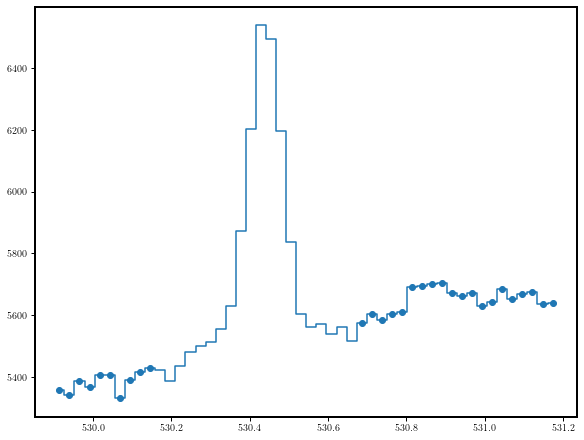

In [99]:
fig, ax = plt.subplots(figsize=(8,6),constrained_layout=True)
ax.step(green_frame_wavelength[FeXIV_62nd_xslice]/62./10., np.average(green_frame_example.data[150:160,FeXIV_62nd_xslice],axis=0),where="mid")

ax.scatter(green_frame_wavelength[FeXIV_62nd_xslice][np.r_[0:20,40:50]]/62./10.,
            np.average(green_frame_example.data[150:160,FeXIV_62nd_xslice],axis=0)[np.r_[0:20,40:50]])
calculate_intensity_single(green_frame_wavelength[FeXIV_62nd_xslice][np.r_[0:20,40:50]]/62./10.,
                np.average(green_frame_example.data[150:160,FeXIV_62nd_xslice],axis=0)[np.r_[0:20,40:50]],
    green_frame_wavelength[FeXIV_62nd_xslice]/62./10.,np.average(green_frame_example.data[150:160,FeXIV_62nd_xslice],axis=0))


/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:204: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")


array([5.30439222e+02, 1.13184248e+02, 1.01308919e-01])

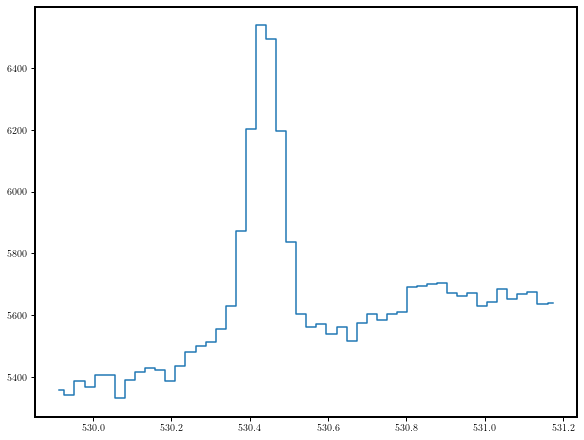

In [104]:
fig, ax = plt.subplots(figsize=(8,6),constrained_layout=True)
ax.step(green_frame_wavelength[FeXIV_62nd_xslice]/62./10., np.average(green_frame_example.data[150:160,FeXIV_62nd_xslice],axis=0),where="mid")

fit_spectra_single(green_frame_wavelength[FeXIV_62nd_xslice][np.r_[0:20,40:50]]/62./10.,
                np.average(green_frame_example.data[150:160,FeXIV_62nd_xslice],axis=0)[np.r_[0:20,40:50]],
    green_frame_wavelength[FeXIV_62nd_xslice]/62./10.,np.average(green_frame_example.data[150:160,FeXIV_62nd_xslice],axis=0))

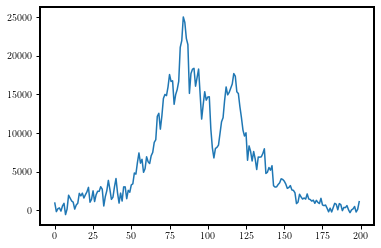

In [118]:
plt.plot(calculate_intensity(green_frame_example.data/flatfield_1d_FeXIV_62nd[:,np.newaxis],green_frame_wavelength, FeXIV_62nd_xslice, FeXIV_62nd_yslice, 
                    slice(0,10),slice(40,50)))

In [186]:
green_intensity_matrix = np.full((200,44),np.nan)
starttime_green = datetime(2017,8,21,17,46,38)

for ii, row_ in totality_green_df_cut.iterrows(): 
    date_obs = row_["date-obs"]
    exptime = np.float64(row_["exptime"])

    time_difference = date_obs - starttime_green
    startindex = int(time_difference.total_seconds()*2)
    endindex = startindex + int(exptime*2)

    green_frame_ = CCDData.read(os.path.join(green_path,row_["file"]),hdu=0,unit="adu")
    green_frame_wavelength_ = CCDData.read(os.path.join(green_path,row_["file"]),hdu=1,unit="adu").data

    FeXIV_int_ = calculate_intensity(green_frame_.data/flatfield_1d_FeXIV_62nd[:,np.newaxis]/exptime,green_frame_wavelength_, FeXIV_62nd_xslice, FeXIV_62nd_yslice, 
                    slice(0,10),slice(40,50))

    green_intensity_matrix[:,startindex:endindex] = FeXIV_int_[:,np.newaxis]
    
green_intensity_matrix = np.flip(green_intensity_matrix)


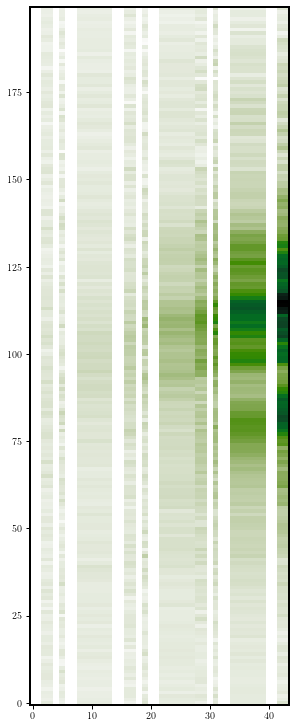

In [187]:
fig, ax = plt.subplots(figsize=(4,10),constrained_layout=True)
ax.pcolormesh(np.arange(44),np.arange(200),green_intensity_matrix,cmap=cmr.jungle_r, rasterized=True)
# ax.invert_yaxis()

In [188]:
green_fit_matrix = np.full((3,200,44),np.nan,dtype=np.float64)
for ii, row_ in totality_green_df_cut.iterrows(): 
    date_obs = row_["date-obs"]
    exptime = np.float64(row_["exptime"])

    time_difference = date_obs - starttime_green
    startindex = int(time_difference.total_seconds()*2)
    endindex = startindex + int(exptime*2)

    green_frame_ = CCDData.read(os.path.join(green_path,row_["file"]),hdu=0,unit="adu")
    green_frame_wavelength_ = CCDData.read(os.path.join(green_path,row_["file"]),hdu=1,unit="adu").data

    FeXIV_fit_ = fit_spectra(green_frame_.data/flatfield_1d_FeXIV_62nd[:,np.newaxis]/exptime,green_frame_wavelength_, FeXIV_62nd_xslice, FeXIV_62nd_yslice, 
                    slice(0,10),slice(40,50))

    green_fit_matrix[:,:,startindex:endindex] = FeXIV_fit_[:,:,np.newaxis]
green_fit_matrix = np.flip(green_fit_matrix,axis=(1,2))

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:204: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:268: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diagonal(pcov))


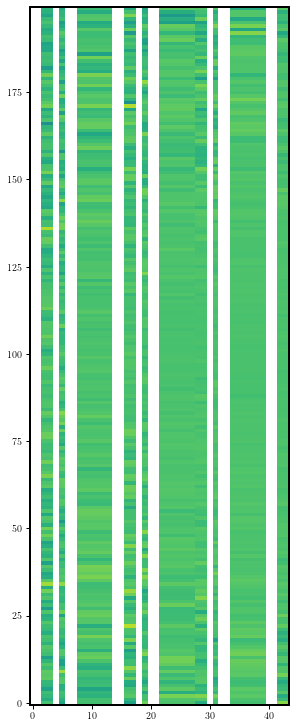

In [190]:
fig, ax = plt.subplots(figsize=(4,10),constrained_layout=True)
ax.pcolormesh(np.arange(44),np.arange(200),green_fit_matrix[2,:,:],vmin=0,vmax=1.5,rasterized=True)

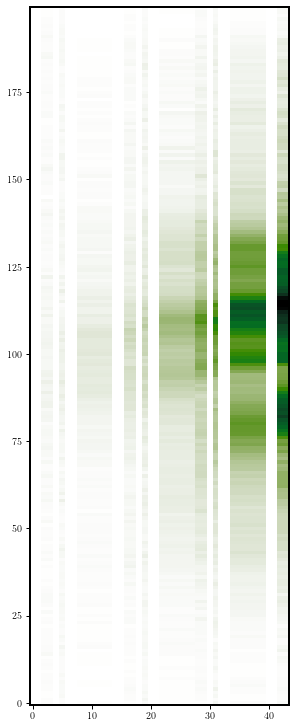

In [191]:
fig, ax = plt.subplots(figsize=(4,10),constrained_layout=True)
ax.pcolormesh(np.arange(44),np.arange(200),green_fit_matrix[1,:,:],cmap=cmr.jungle_r,rasterized=True)

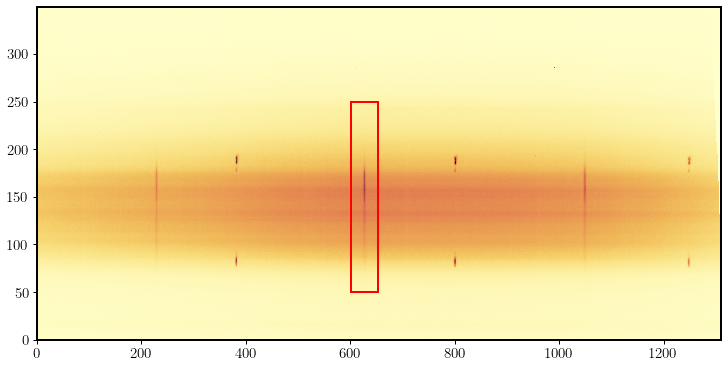

In [156]:
fig, ax = plt.subplots(figsize=(10,5),constrained_layout=True)
red_frame_example = CCDData.read(os.path.join(red_path,totality_red_df_cut.iloc[0]["file"]),hdu=0,unit="adu")
red_frame_wavelength = CCDData.read(os.path.join(red_path,totality_red_df_cut.iloc[0]["file"]),hdu=1,unit="adu").data
ax.pcolormesh(np.arange(red_frame_example.header["NAXIS1"]),
                np.arange(red_frame_example.header["NAXIS2"]),
                red_frame_example.data,cmap=cmcm.lajolla,rasterized=True)

FeX_52nd_xslice = slice(602,652)
FeX_52nd_yslice = slice(50,250)
cutout_rectangle_52nd = patches.Rectangle((FeX_52nd_xslice.start, FeX_52nd_yslice.start), 
                    FeX_52nd_xslice.stop - FeX_52nd_xslice.start,
                    FeX_52nd_yslice.stop - FeX_52nd_yslice.start,
                    edgecolor="red",facecolor='none',lw=2)
ax.add_patch(cutout_rectangle_52nd)
ax.tick_params(labelsize=15)

13918.340508150717

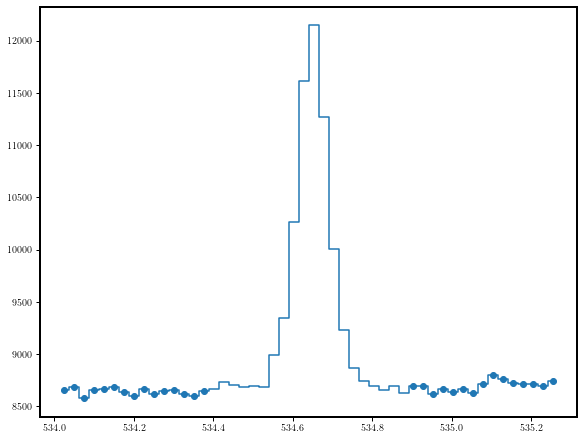

In [157]:
fig, ax = plt.subplots(figsize=(8,6),constrained_layout=True)
ax.step(red_frame_wavelength[FeX_52nd_xslice]/62./10., np.average(red_frame_example.data[150:160,FeX_52nd_xslice],axis=0),where="mid")

ax.scatter(red_frame_wavelength[FeX_52nd_xslice][np.r_[0:15,35:50]]/62./10.,
            np.average(red_frame_example.data[150:160,FeX_52nd_xslice],axis=0)[np.r_[0:15,35:50]])
calculate_intensity_single(red_frame_wavelength[FeX_52nd_xslice][np.r_[0:15,35:50]]/62./10.,
                np.average(red_frame_example.data[150:160,FeX_52nd_xslice],axis=0)[np.r_[0:15,35:50]],
    red_frame_wavelength[FeX_52nd_xslice]/62./10.,np.average(red_frame_example.data[150:160,FeX_52nd_xslice],axis=0))


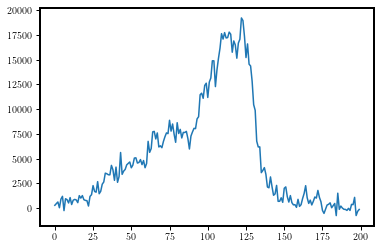

In [158]:
plt.plot(calculate_intensity(red_frame_example.data/flatfield_1d_FeX_52nd[:,np.newaxis],red_frame_wavelength, FeX_52nd_xslice, FeX_52nd_yslice, 
                    slice(0,15),slice(35,50)))

In [192]:
red_intensity_matrix = np.full((200,44),np.nan)
starttime_red = datetime(2017,8,21,17,46,38)

for ii, row_ in totality_red_df_cut.iterrows(): 
    date_obs = row_["date-obs"]
    exptime = np.float64(row_["exptime"])

    time_difference = date_obs - starttime_red
    startindex = int(time_difference.total_seconds()*2)
    endindex = startindex + int(exptime*2)

    red_frame_ = CCDData.read(os.path.join(red_path,row_["file"]),hdu=0,unit="adu")
    red_frame_wavelength_ = CCDData.read(os.path.join(red_path,row_["file"]),hdu=1,unit="adu").data

    FeX_int_ = calculate_intensity(red_frame_.data/flatfield_1d_FeX_52nd[:,np.newaxis]/exptime,red_frame_wavelength_, FeX_52nd_xslice, FeX_52nd_yslice, 
                    slice(0,10),slice(40,50))

    red_intensity_matrix[:,startindex:endindex] = FeX_int_[:,np.newaxis]
    
red_intensity_matrix = np.flip(red_intensity_matrix)


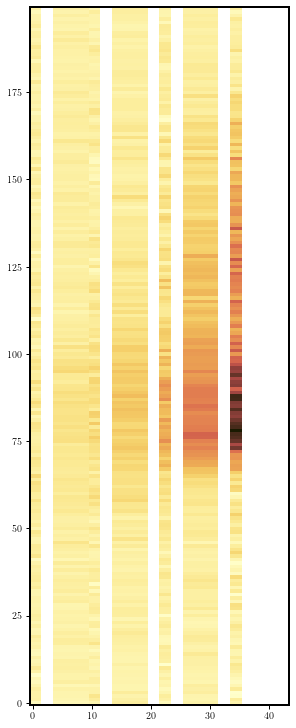

In [193]:
fig, ax = plt.subplots(figsize=(4,10),constrained_layout=True)
ax.pcolormesh(np.arange(44),np.arange(200),red_intensity_matrix,cmap=cmcm.lajolla, rasterized=True)

In [194]:
red_fit_matrix = np.full((3,200,44),np.nan,dtype=np.float64)
for ii, row_ in totality_red_df_cut.iterrows(): 
    date_obs = row_["date-obs"]
    exptime = np.float64(row_["exptime"])

    time_difference = date_obs - starttime_red
    startindex = int(time_difference.total_seconds()*2)
    endindex = startindex + int(exptime*2)

    red_frame_ = CCDData.read(os.path.join(red_path,row_["file"]),hdu=0,unit="adu")
    red_frame_wavelength_ = CCDData.read(os.path.join(red_path,row_["file"]),hdu=1,unit="adu").data

    FeX_fit_ = fit_spectra(red_frame_.data/flatfield_1d_FeX_52nd[:,np.newaxis]/exptime,red_frame_wavelength_, FeX_52nd_xslice, FeX_52nd_yslice, 
                    slice(0,10),slice(40,50))

    red_fit_matrix[:,:,startindex:endindex] = FeX_fit_[:,:,np.newaxis]

red_fit_matrix = np.flip(red_fit_matrix,axis=(1,2))

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:204: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:268: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diagonal(pcov))


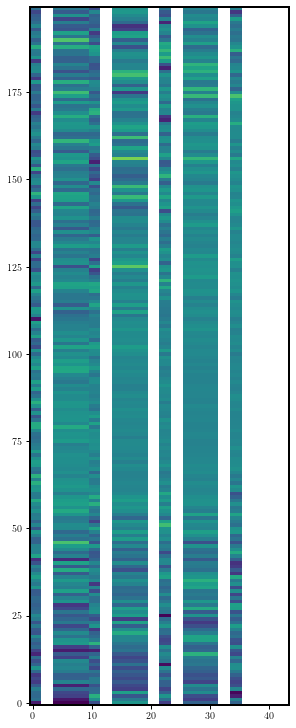

In [195]:
fig, ax = plt.subplots(figsize=(4,10),constrained_layout=True)
ax.pcolormesh(np.arange(44),np.arange(200),red_fit_matrix[2,:,:],vmin=0.7,vmax=1.5,rasterized=True)

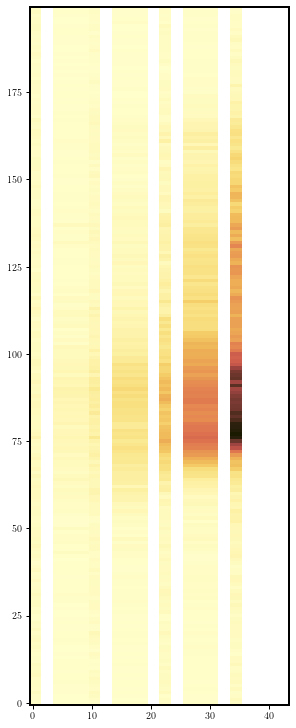

In [196]:
fig, ax = plt.subplots(figsize=(4,10),constrained_layout=True)
ax.pcolormesh(np.arange(44),np.arange(200),red_fit_matrix[1,:,:],cmap=cmcm.lajolla,rasterized=True)

In [202]:
green_limb_loc = np.array([396.,625.,])
x_1d_grid_green = np.arange(-43,1,1,dtype=np.float64)
y_1d_grid_green = np.arange(np.mean(green_limb_loc) - 649.,  np.mean(green_limb_loc) - 449., 1, dtype=np.float64) 

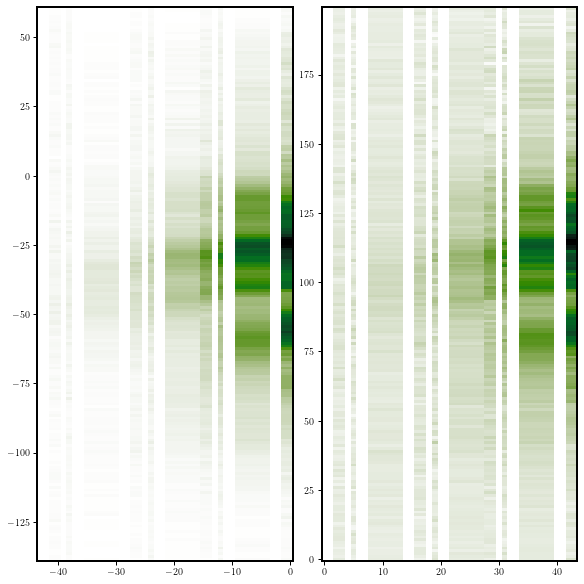

In [204]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,8),constrained_layout=True)
ax1.pcolormesh(x_1d_grid_green,y_1d_grid_green,green_fit_matrix[1,:,:],cmap=cmr.jungle_r,rasterized=True)
ax2.pcolormesh(np.arange(44),np.arange(200),green_intensity_matrix,cmap=cmr.jungle_r, rasterized=True)

In [251]:
y_1d_grid_green_arcsec = y_1d_grid_green/(np.diff(green_limb_loc)/2.)*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
x_1d_grid_green_arcsec = x_1d_grid_green * (sun_x_fitpoly(10) - sun_x_fitpoly(9.5))/pixel_ratio_to_arcsec

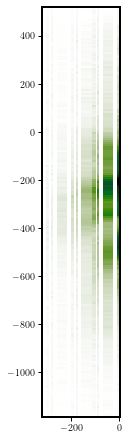

In [252]:
fig, ax = plt.subplots(figsize=(8,6),constrained_layout=True)
ax.pcolormesh(x_1d_grid_green_arcsec,y_1d_grid_green_arcsec,green_fit_matrix[1,:,:],cmap=cmr.jungle_r,rasterized=True)
ax.set_aspect(1)

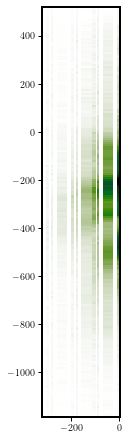

In [253]:
x_2d_grid_green_arcsec, y_2d_grid_green_arcsec = np.meshgrid(x_1d_grid_green_arcsec, y_1d_grid_green_arcsec)
fig, ax = plt.subplots(figsize=(8,6),constrained_layout=True)
ax.pcolormesh(x_2d_grid_green_arcsec,y_2d_grid_green_arcsec,green_fit_matrix[1,:,:],cmap=cmr.jungle_r,rasterized=True)
ax.set_aspect(1)

In [264]:
rotate_angle_context = -28

In [265]:
x_2d_grid_green_arcsec_rot = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec

y_2d_grid_green_arcsec_rot = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec

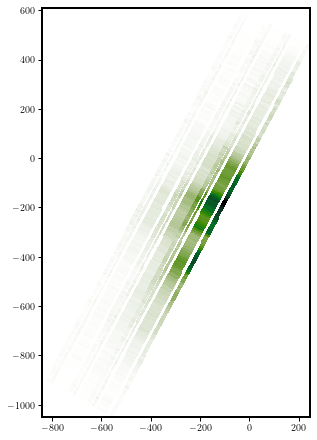

In [266]:
x_2d_grid_green_arcsec, y_2d_grid_green_arcsec = np.meshgrid(x_1d_grid_green_arcsec, y_1d_grid_green_arcsec)
fig, ax = plt.subplots(figsize=(8,6),constrained_layout=True)
ax.pcolormesh(x_2d_grid_green_arcsec_rot,y_2d_grid_green_arcsec_rot,green_fit_matrix[1,:,:],cmap=cmr.jungle_r,rasterized=True)
ax.set_aspect(1)

In [267]:
def func_img_xpixel_to_xarcsec(x):
    return (x - img_center[0])/img_pixel_to_arcsec

def func_img_xarcsec_to_xpixel(x):
    return x*img_pixel_to_arcsec + img_center[0]

def func_img_ypixel_to_yarcsec(x):
    return (x - img_center[1])/img_pixel_to_arcsec

def func_img_yarcsec_to_ypixel(x):
    return x*img_pixel_to_arcsec + img_center[1]

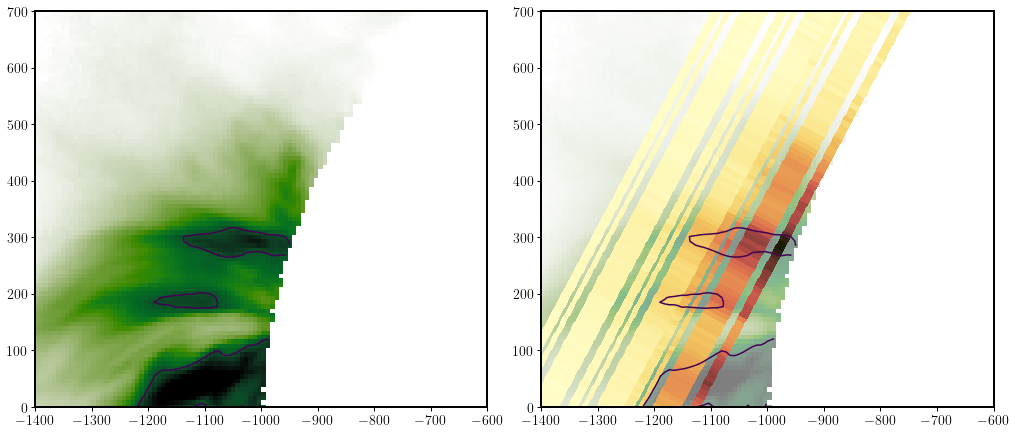

In [268]:
img_center = np.array([300,220])
img_xpixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[1])
img_ypixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[0])

img_xarcsec_array = func_img_xpixel_to_xarcsec(img_xpixel_array)
img_yarcsec_array = func_img_ypixel_to_yarcsec(img_ypixel_array)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6),constrained_layout=True)
ax1.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,vmin=0.2,vmax=1.2,
                    cmap=cmr.jungle_r,shading="auto",rasterized=True)
ax1.contour(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,levels=[0.9])

ax2.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,vmin=0.2,vmax=1.2,
                    cmap=cmr.jungle_r,shading="auto",rasterized=True,alpha=0.5)
ax2.contour(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,levels=[0.9])

slit_xshift_green = sun_x_fitpoly(62) - slit_pos

slit_center_x_green =  - slit_xshift_green/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
slit_center_y_green =  slit_xshift_green/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

ax2.pcolormesh(x_2d_grid_green_arcsec_rot + slit_center_x_green,
                y_2d_grid_green_arcsec_rot + slit_center_y_green,
                green_fit_matrix[1,:,:],cmap=cmcm.lajolla,rasterized=True)

xlim_zoomin = [-1400,-600]
ylim_zoomin = [0,700]
for ax_ in (ax1,ax2):
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)
    ax_.set_xlim(xlim_zoomin)
    ax_.set_ylim(ylim_zoomin)